In [256]:
from anyio import current_effective_deadline
from jedi.debug import speed
from mistune.plugins.speedup import speedup
from numba.cuda.libdevice import fmax
from scipy.constants import speed_of_light
%matplotlib inline
from scipy import signal
from scipy.io import wavfile
import scipy.integrate
import IPython.display as ipyd
import librosa
import librosa.display
import librosa.feature
import matplotlib.pyplot as plt
import numpy as np

In [257]:
minHz = 125
maxHz = 3000
stft_frame_len = 0.033
stft_frame_trans = 0.015
mels_amount = 40
n_mfcc = 13


# Comparison Files

In [258]:
def load_plot(path: str):
    #Load and display
    file_sample_rate, file_wav = wavfile.read(path)
    ipyd.display(ipyd.Audio(rate=file_sample_rate, data=file_wav))
    file_n = len(file_wav)

    #plot wav
    plt.figure(figsize=(4,2))
    plt.plot(np.linspace(0, file_n/file_sample_rate, file_n), file_wav)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

    # FFT
    plt.figure(figsize=(4,2))
    file_fft = np.fft.fft(file_wav)[minHz:maxHz]
    file_fft_n = len(file_fft)
    plt.plot(np.linspace(0, file_sample_rate*(file_fft_n - 1)/file_fft_n, file_fft_n), np.abs(file_fft))
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.show()
    return file_sample_rate, file_wav, file_n, file_fft

In [259]:
def spectrum_stft(wave, sample_rate, should_print = False):
    samples_frame = int(stft_frame_len * sample_rate)
    samples_transition = int(stft_frame_trans * sample_rate)
    wave = wave.astype(np.float32)

    # normalize
    wave /= np.max(np.abs(wave),axis=0)

    stft = librosa.stft(wave, n_fft=samples_frame, hop_length=samples_transition)
    if should_print:
        fig, ax = plt.subplots(figsize=(4, 2))
        librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft)),
                                 y_axis='hz',
                                 x_axis='time',
                                 ax=ax,
                                 fmax = maxHz,
                                 fmin = minHz )
        plt.show()

    mel_spectrum = librosa.feature.melspectrogram(
        y=wave, sr=sample_rate, n_mels=n_mfcc,
        n_fft=samples_frame, hop_length=samples_transition
    )

    log_mel_spectrum = librosa.power_to_db(mel_spectrum)

    mfccs = librosa.feature.mfcc(S=log_mel_spectrum, n_mfcc=mels_amount)

    # 4. Extract C0
    # librosa returns shape (n_mfcc, time_steps), so row 0 is C0.
    c0_energy_profile = mfccs[0]

    #print(c0_energy_profile.min(),  " ", c0_energy_profile.max(), " ", c0_energy_profile.mean())
    if False:
        plt.figure(figsize=(10, 6))
        # 1. Plot the Histogram
        counts, bins, _ = plt.hist(mfccs[0], bins=50, color='gray', alpha=0.7, label='Data Distribution')

        # 2. visual helper
        plt.title("Histogram of C0 (Log Energy)")
        plt.xlabel("C0 Value (Loudness)")
        plt.ylabel("Frequency (Count of Frames)")
        plt.grid(axis='y', alpha=0.5)

        plt.show()

    if should_print:
        fig, ax = plt.subplots(figsize=(4, 2))
        print(log_mel_spectrum.shape)
        librosa.display.specshow(log_mel_spectrum,
                                 y_axis='hz',
                                 x_axis='time',
                                 ax=ax,
                                 fmax = maxHz,
                                 fmin = minHz )
        plt.show()

    if should_print:
        fig, ax = plt.subplots(figsize=(4, 2))
        print(log_mel_spectrum.shape)
        librosa.display.specshow(mfccs,
                                 y_axis='hz',
                                 x_axis='time',
                                 ax=ax,
                                 fmax = maxHz,
                                 fmin = minHz )
        plt.show()

    return mfccs


In [260]:
def diff_fft(a: np.ndarray, b: np.ndarray, sample_rate: int) -> np.ndarray:

    # diff add
    plt.figure(figsize=(4,2))
    n = len(a)
    x = np.linspace(0, sample_rate*(n - 1)/n, n)
    curve = np.abs(np.abs(a)*4 - np.abs(b))
    plt.plot(x, curve)
    print(np.trapezoid(curve)/100000)

    plt.xlabel("Frequency")
    plt.ylabel("Difference")
    plt.show()

    plt.plot(x, np.abs(a))
    plt.plot(x, np.abs(b))

    idx = np.argwhere(np.diff(np.abs(a) - np.abs(b))).flatten()
    plt.plot(x[idx], np.abs(a)[idx], 'ro')

    plt.show()

    return idx


## Start

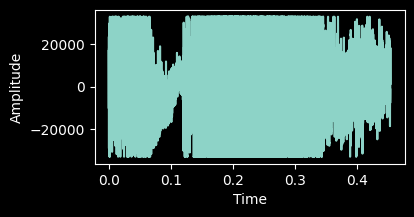

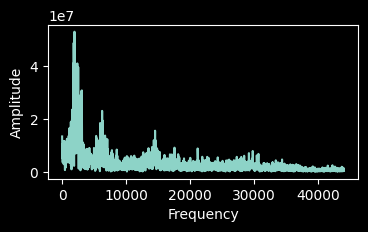

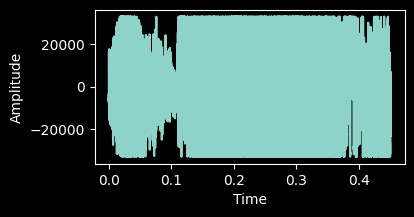

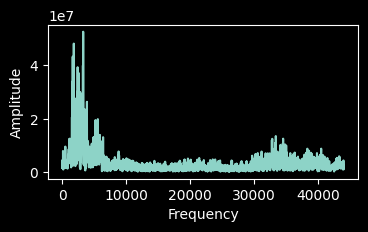

290479.8913680612


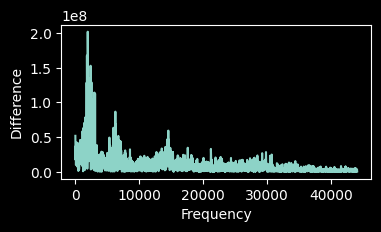

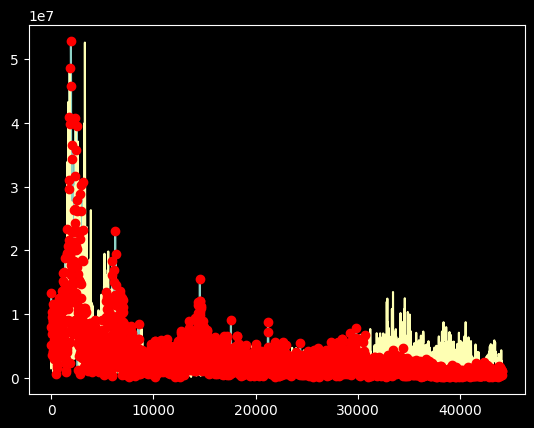

In [261]:
# Load
startFile_sample_rate, startFile_wav, startFile_n, startFile_fft = load_plot("./wav/start.wav")

# load mariusz start
startFileMariusz_sample_rate, startFileMariusz_wav, startFileMariusz_n, startFileMariusz_fft = load_plot("./wav/startMariusz.wav")

diff_fft(startFile_fft, startFileMariusz_fft, startFile_sample_rate)

startFile_mel = spectrum_stft(startFile_wav, startFile_sample_rate)
startFileMariusz_mel= spectrum_stft(startFileMariusz_wav, startFileMariusz_sample_rate)

## Stop

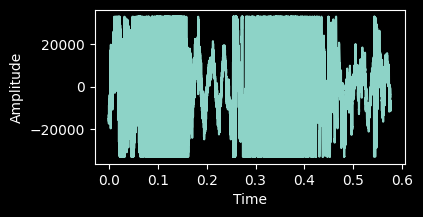

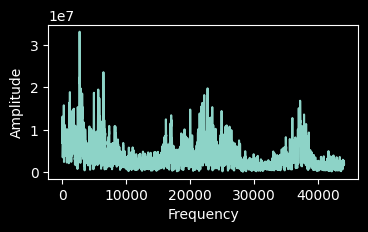

In [262]:
stopFile_sample_rate, stopFile_wav, stopFile_n, stopFile_fft = load_plot("./wav/stop.wav")

stopFile_mel = spectrum_stft(stopFile_wav, stopFile_sample_rate)

## Plus

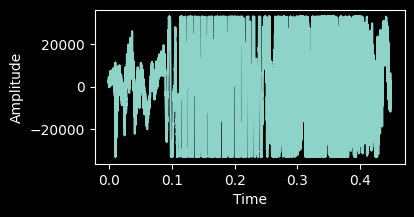

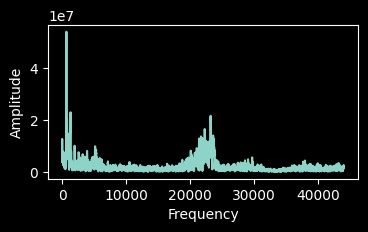

In [263]:
plusFile_sample_rate, plusFile_wav, plusFile_n, plusFile_fft = load_plot("./wav/plus.wav")

plusFile_mel = spectrum_stft(plusFile_wav, plusFile_sample_rate)


## Minus

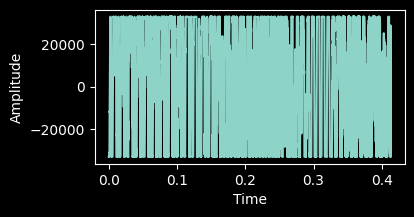

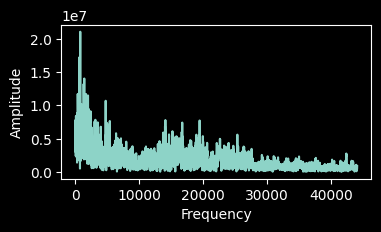

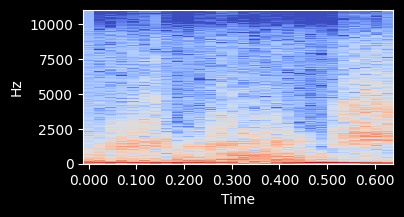

(13, 28)


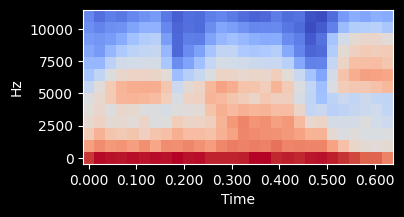

(13, 28)


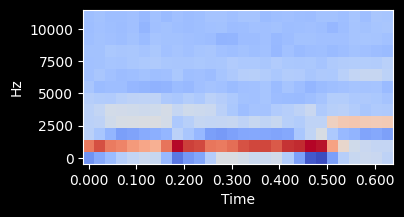

In [264]:
minusFile_sample_rate, minusFile_wav, minusFile_n, minusFile_fft = load_plot("./wav/minus.wav")

minusFile_mel = spectrum_stft(minusFile_wav, minusFile_sample_rate, True)


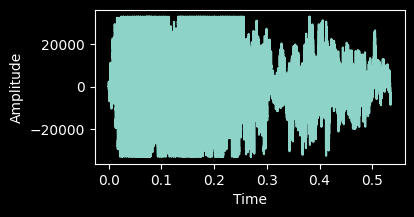

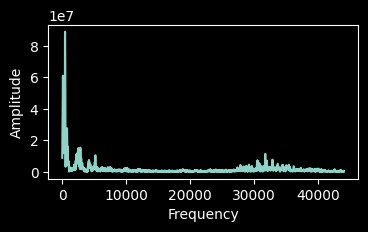

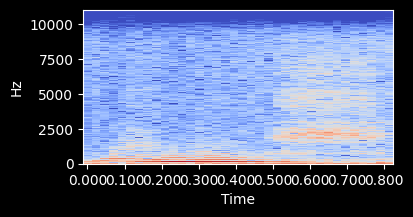

(13, 36)


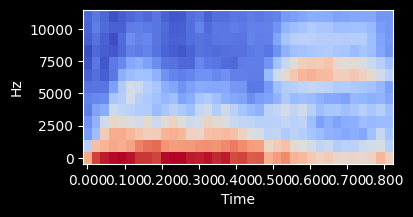

(13, 36)


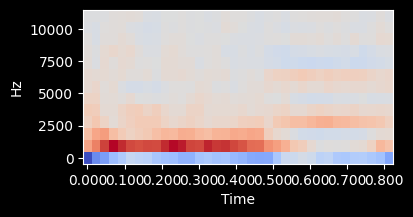

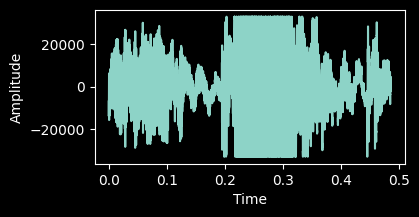

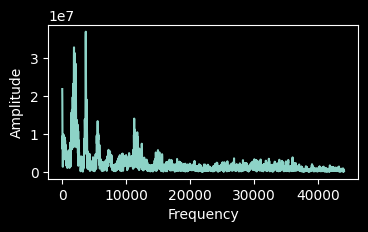

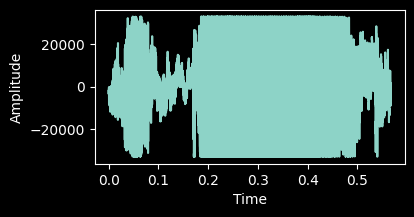

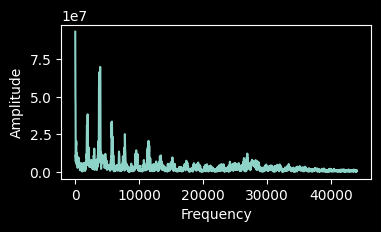

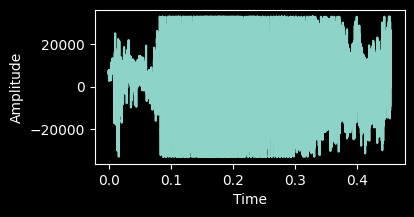

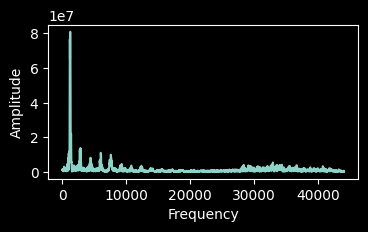

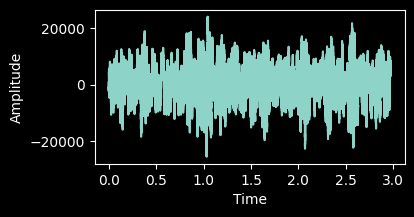

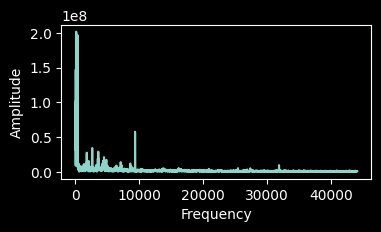

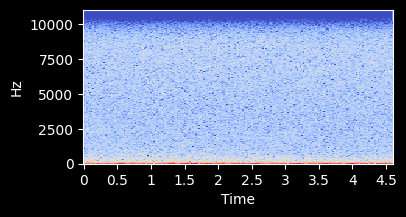

(13, 199)


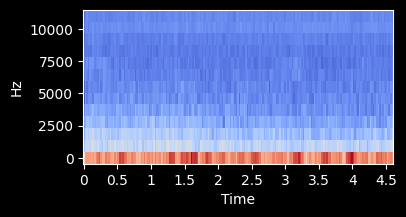

(13, 199)


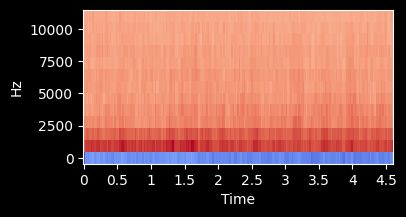

In [265]:
patiMinus_sample_rate, patiMinus_wav, patiMinus_n, patiMinus_fft = load_plot("./wav/patiMinus.wav")
patiMinus_mel = spectrum_stft(patiMinus_wav, patiMinus_sample_rate, True)

patiStop_sample_rate, patiStop_wav, patiStop_n, patiStop_fft = load_plot("./wav/patiStop.wav")
patiStop_mel = spectrum_stft(patiStop_wav, patiStop_sample_rate)

patiStart_sample_rate, patiStart_wav, patiStart_n, patiStart_fft = load_plot("./wav/patiStart.wav")
patiStart_mel = spectrum_stft(patiStart_wav, patiStart_sample_rate)

patiPlus_sample_rate, patiPlus_wav, patiPlus_n, patiPlus_fft = load_plot("./wav/patiPlus.wav")
patiPlus_mel = spectrum_stft(patiPlus_wav, patiPlus_sample_rate)

noice_sample_rate, noice_wav, noice_n, noice_fft = load_plot("./wav/noice.wav")
noice_mel = spectrum_stft(noice_wav, noice_sample_rate, True)

In [266]:
def cosine_dist(a: np.ndarray, b: np.ndarray):
    a = a.T
    b = b.T

    comp_len = min(len(a), len(b))

    distances = np.zeros(comp_len)
    for i in range(comp_len):
        distances[i] = scipy.spatial.distance.cosine(a[i], b[i])

    return np.average(distances)


In [267]:
from numpy.lib.stride_tricks import sliding_window_view

def clean_vad(v):
    v = np.hstack([[0],v,[0]])
    # Remove isolated peak
    v_min=[np.min(l) for l in sliding_window_view(v,3)]
    v_min = np.hstack([[0,0],v_min,[0]])
    # Remove isolated hole
    v_max=[np.max(l) for l in sliding_window_view(v_min,4)]
    return v_max

In [268]:
def speach_map(current_mel, speech_threshold):
    s_map = []
    for curr in current_mel[0]:
        if curr >= speech_threshold:
            s_map.append(1)
        else:
            s_map.append(0)

    return clean_vad(s_map)

In [269]:
from scipy.spatial.distance import cdist

def dtw_distance(mfcc1, mfcc2):
    # Calculate the distance matrix between all time steps
    D = cdist(mfcc1, mfcc2, metric='euclidean')

    # Use librosa to find the best path (alignment) through the matrix
    # The last value in the accumulated cost matrix is the total "distance"
    D_accum, wp = librosa.sequence.dtw(C=D)

    # Normalize by path length so longer words don't automatically have higher scores
    distance = D_accum[-1, -1] / len(wp)
    return distance

In [270]:
def find_longest_speech_sequence(arr):
    max_len = 0
    best_start = None
    best_end = None

    n = len(arr)
    i = 0

    # We need at least 3 elements for a valid sequence (0, 1, 0)
    while i < n - 2:
        # 1. Look for the starting '0' followed by a '1'
        if arr[i] == 0 and arr[i+1] == 1:

            # Potential sequence starts at i + 1
            current_start = i + 1
            current_idx = current_start

            # 2. Traverse the 1s
            while current_idx < n and arr[current_idx] == 1:
                current_idx += 1

            # Now current_idx is at the first non-1 element (or out of bounds)

            # 3. Check strictly if the sequence ended with a '0'
            if current_idx < n and arr[current_idx] == 0:
                # Valid sequence found!
                current_end = current_idx - 1
                current_len = (current_end - current_start) + 1

                if current_len > max_len:
                    max_len = current_len
                    best_start = current_start
                    best_end = current_end

                # Optimization: Since arr[current_idx] is 0, it could be the
                # START of a new sequence. We move our main loop iterator 'i'
                # to this index to check it in the next pass.
                i = current_idx
            else:
                # If we ran out of bounds or hit something else (not possible with just 0/1,
                # but good practice), we skip past this block of 1s.
                i = current_idx
        else:
            i += 1

    return best_start, best_end

# --- Test Cases ---

# Case 1: Standard valid case (0 -> 1s -> 0)
data1 = [0, 1, 1, 1, 1, 0]
start, end = find_longest_speech_sequence(data1)
print(f"Data: {data1} \n -> Start: {start}, End: {end}")
print("-" * 20)

# Case 2: Your specific failing case (Ends with 1s, no closing 0)
# This should now return None, None
data2 = [1, 1, 1, 1, 1, 1, 0, 0, 1, 1]
start, end = find_longest_speech_sequence(data2)
print(f"Data: {data2} \n -> Start: {start}, End: {end}")
print("-" * 20)

# Case 3: Multiple valid sequences, picking the longest
data3 = [0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0]
start, end = find_longest_speech_sequence(data3)
print(f"Data: {data3} \n -> Start: {start}, End: {end}")

Data: [0, 1, 1, 1, 1, 0] 
 -> Start: 1, End: 4
--------------------
Data: [1, 1, 1, 1, 1, 1, 0, 0, 1, 1] 
 -> Start: None, End: None
--------------------
Data: [0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0] 
 -> Start: 3, End: 6


In [271]:
def find_match(samples, current_mel, speech_map):
    best_label = None
    best_dist = float("inf")

    dists = []

    start, end = find_longest_speech_sequence(speech_map)

    if start and end and start != end:
        print(end - start)
        search_mel = current_mel.T[1:][start:end+1]
        for mel, label in samples:
            dist = dtw_distance(mel.T, search_mel)
            dists.append(dist)
            if dist < best_dist:
                best_dist = dist
                best_label = label

        return best_label, best_dist
    else:
        return "noise", -1


ALSA lib pcm_dsnoop.c:567:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1000:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
ALSA lib pcm

* recording
Noise Floor: -29.70 (-34.41/-2.54)
Threshold:   4.00


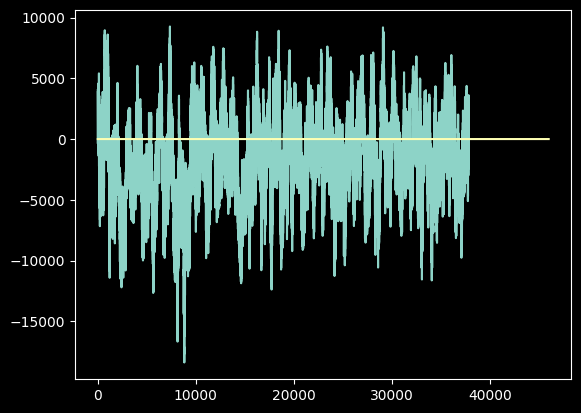

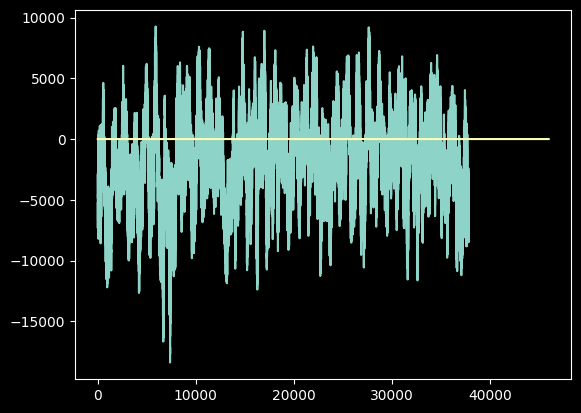

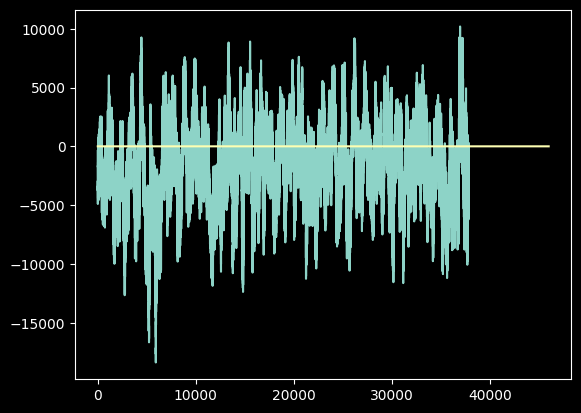

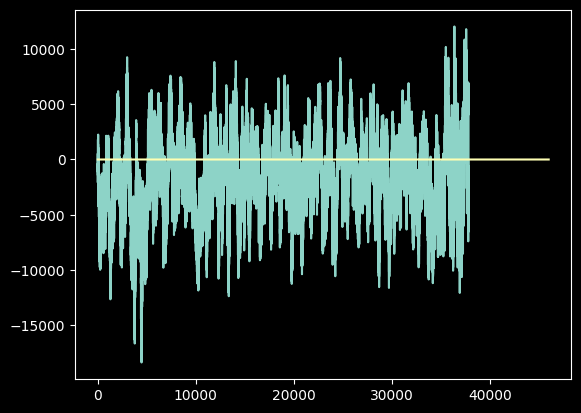

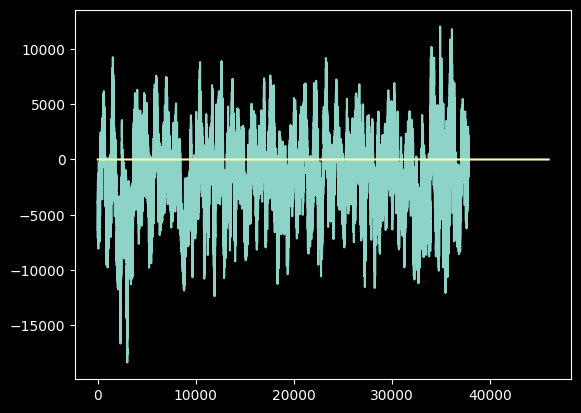

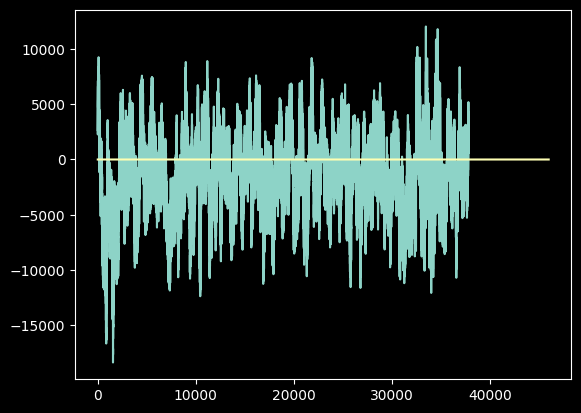

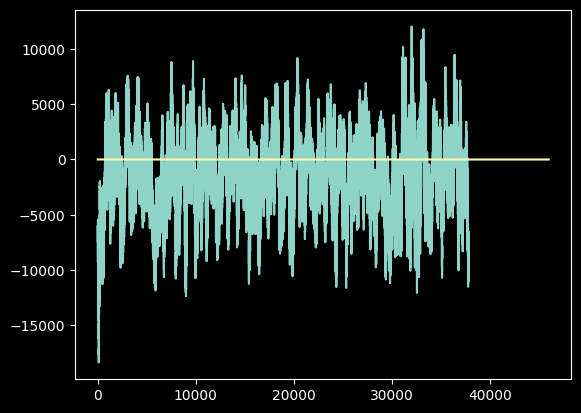

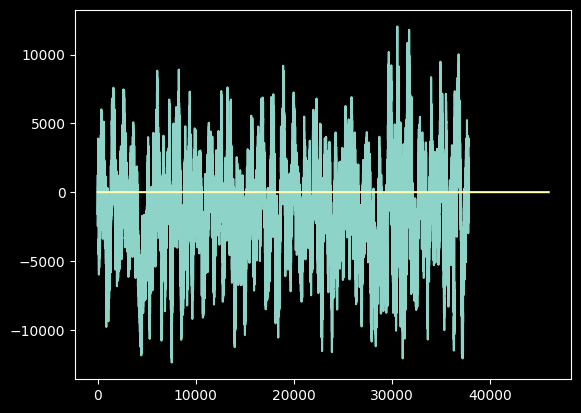

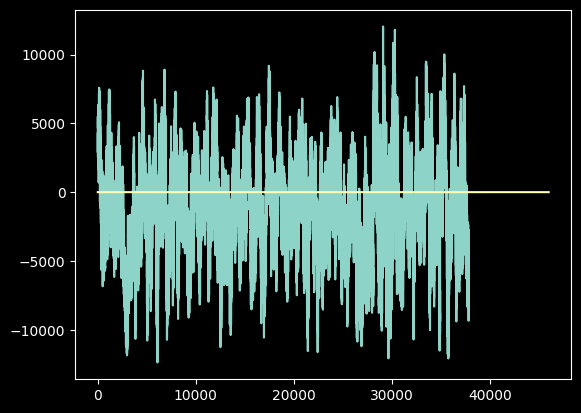

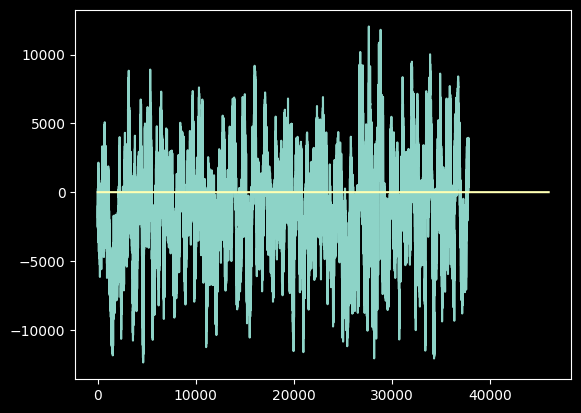

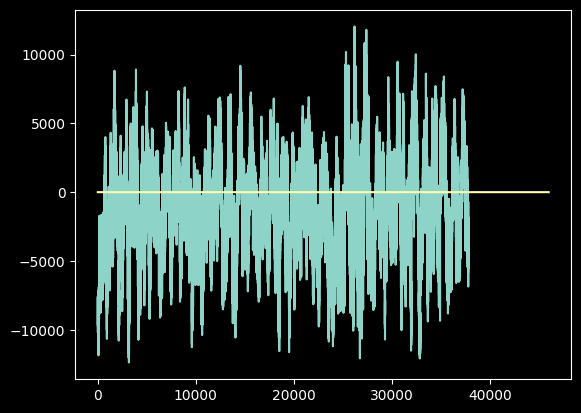

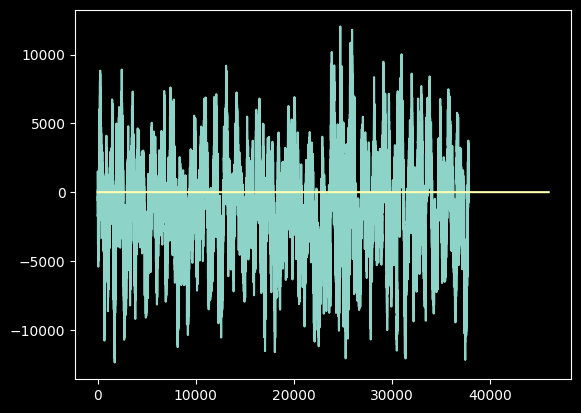

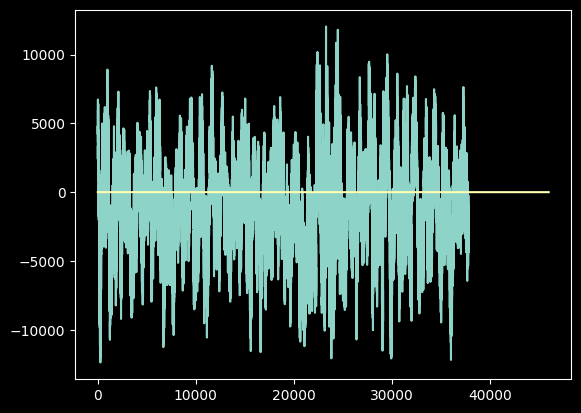

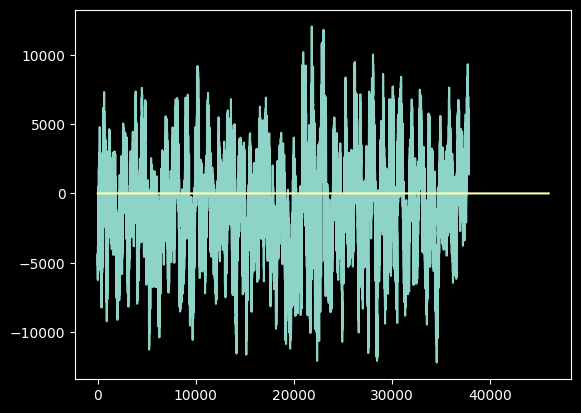

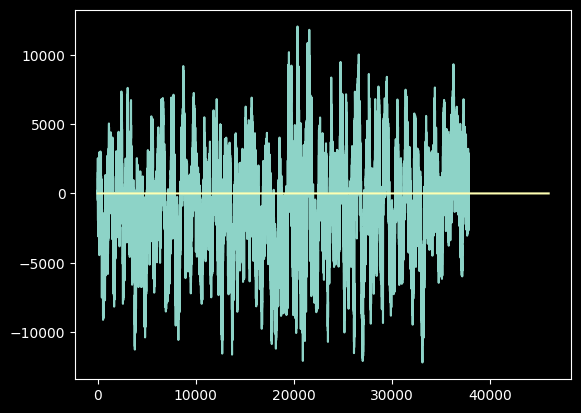

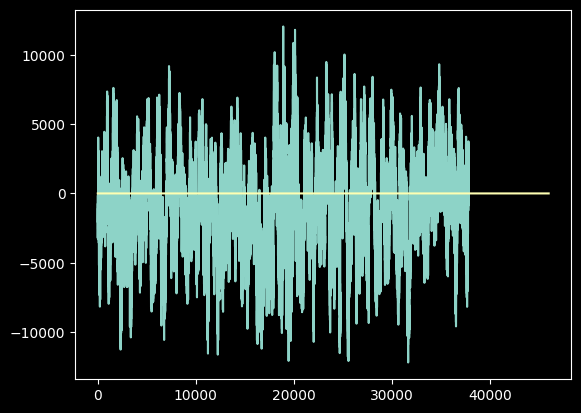

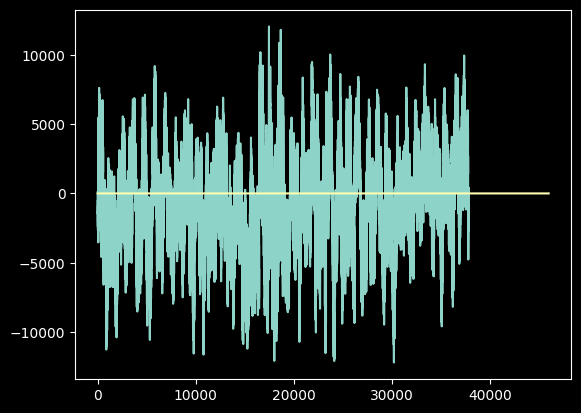

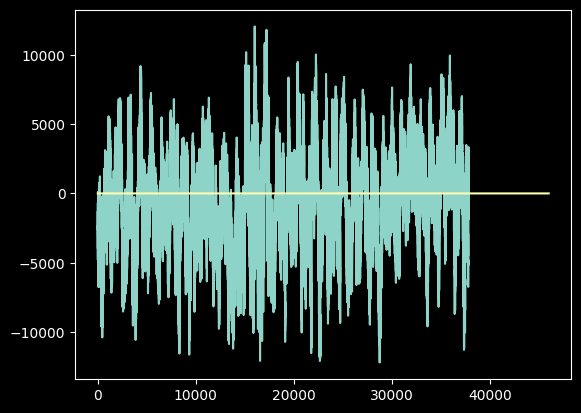

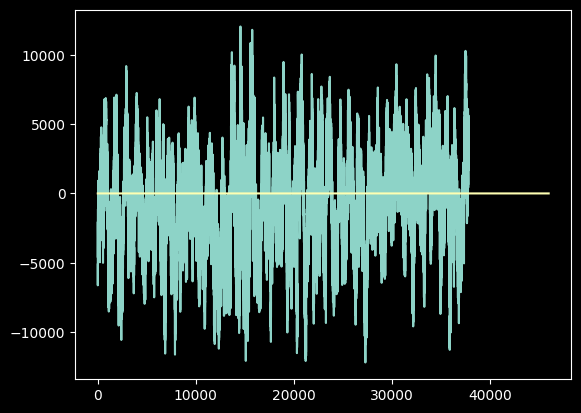

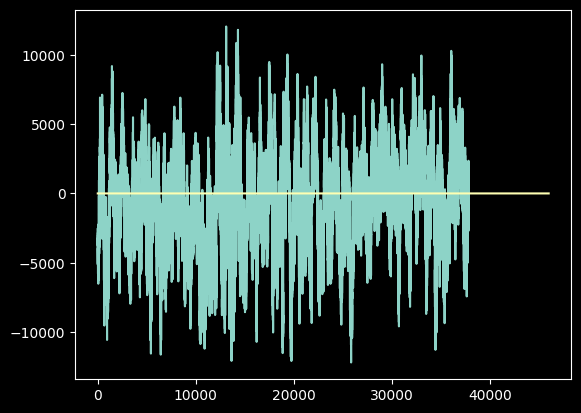

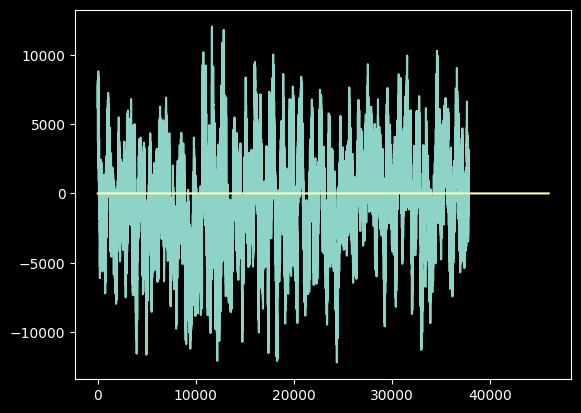

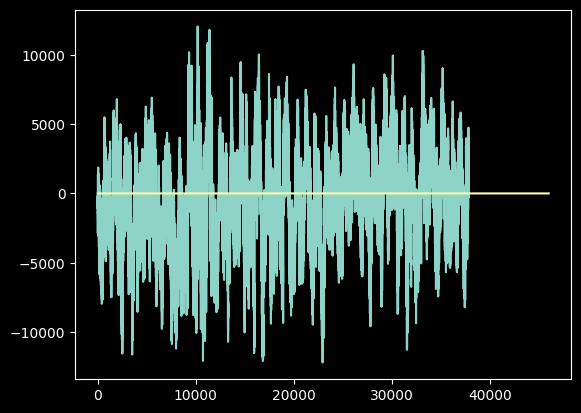

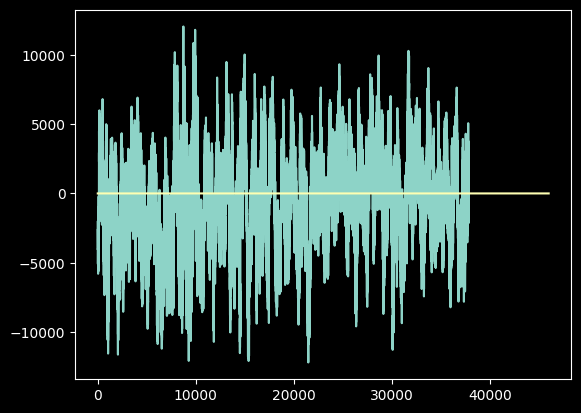

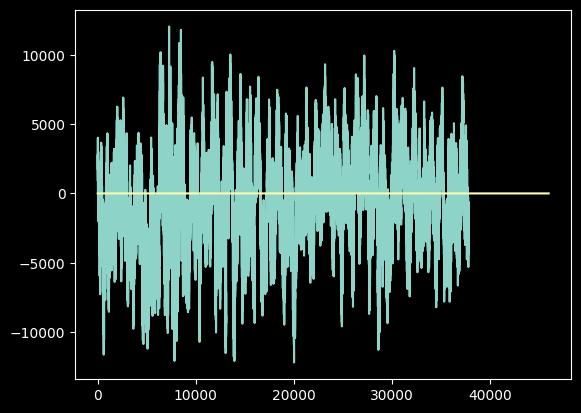

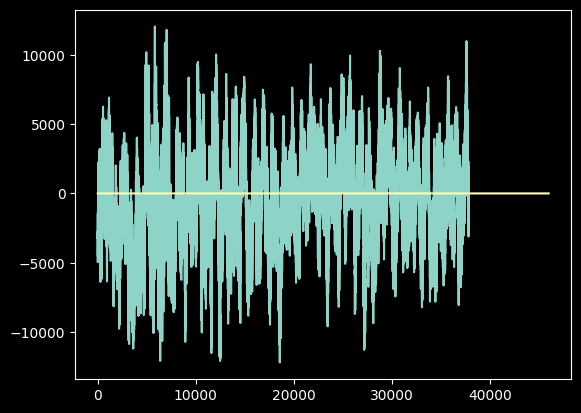

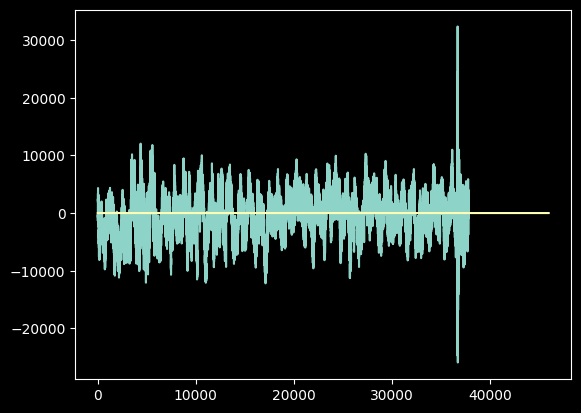

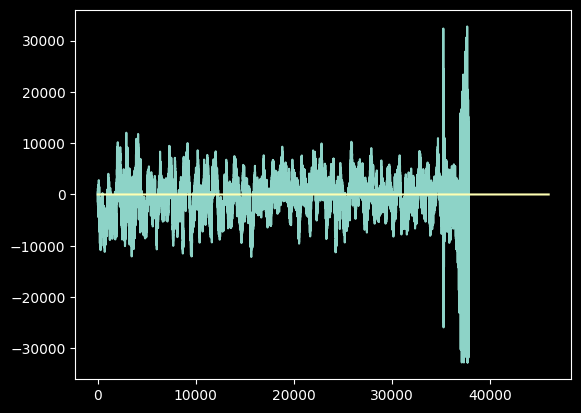

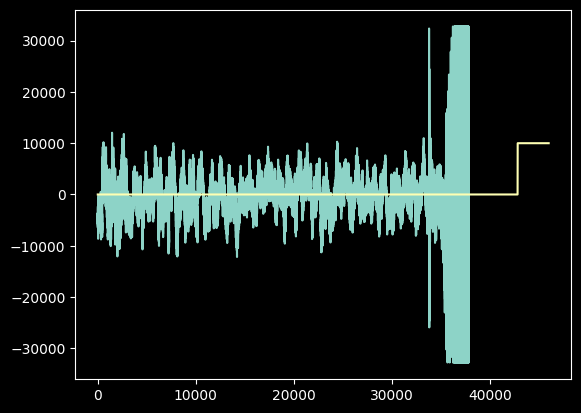

4


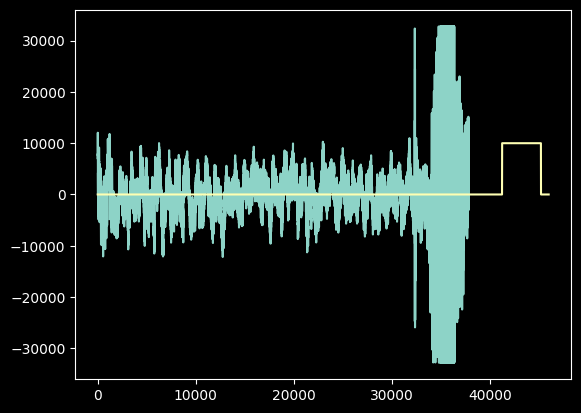

stop   35.224884819107736
4


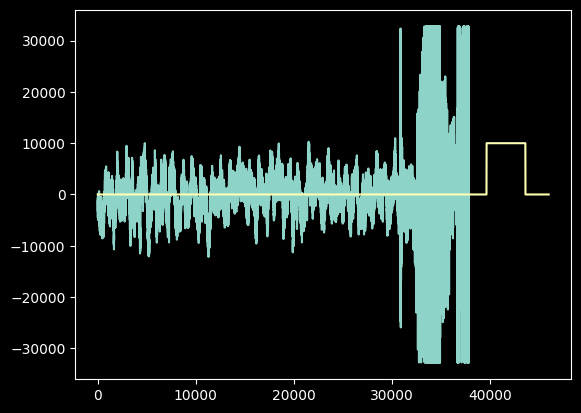

stop   32.24162281929936
3


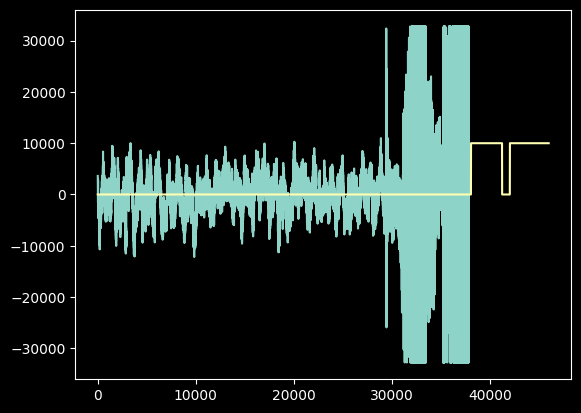

stop   36.62258594533297
3


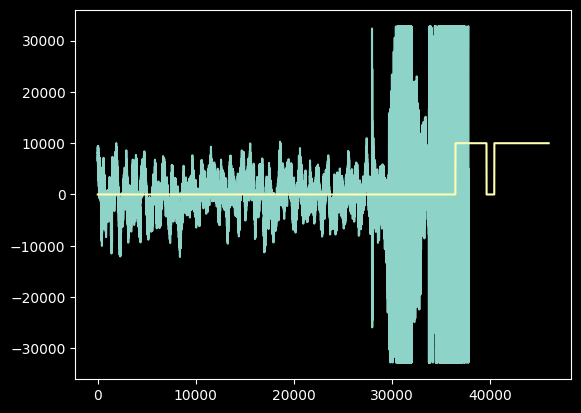

stop   35.93714496248744
4


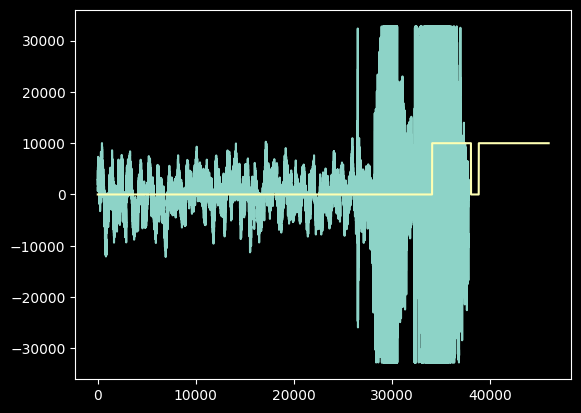

stop   34.869104850534434
7


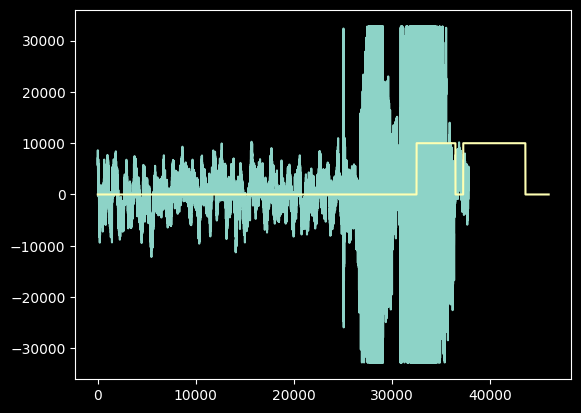

start   21.659483909307305
7


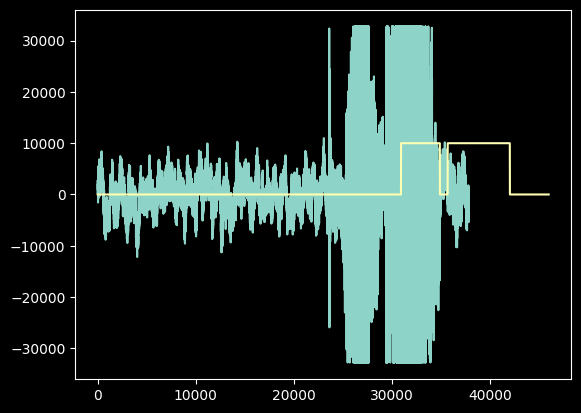

start   22.08532665248116
8


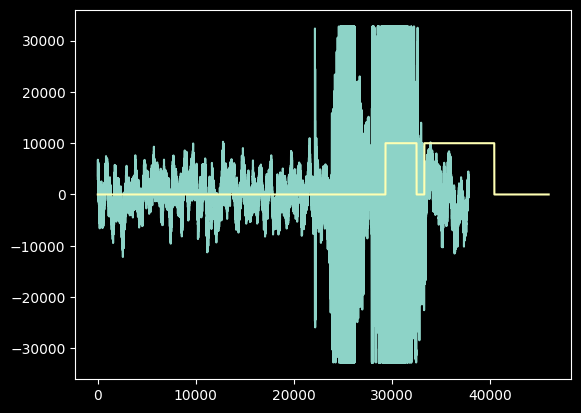

start   18.911411979812346
8


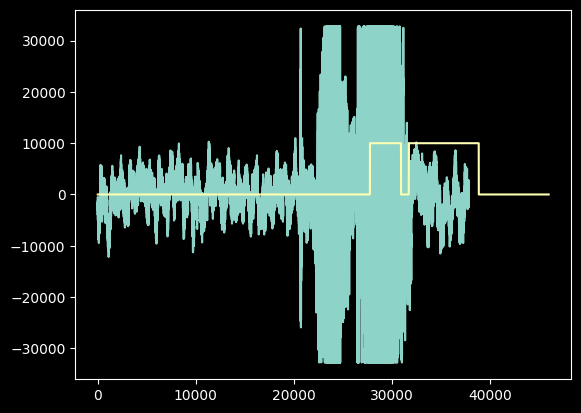

start   20.650918321849996
8


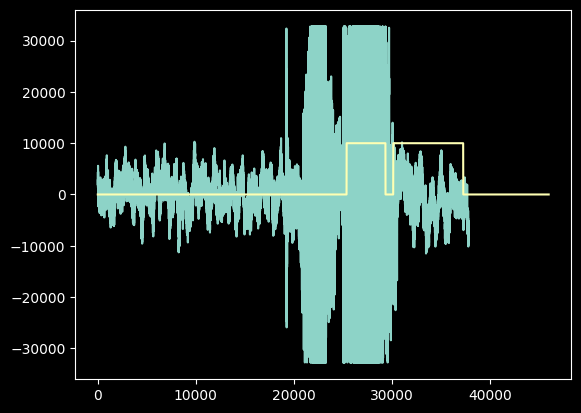

start   22.42391944016784
7


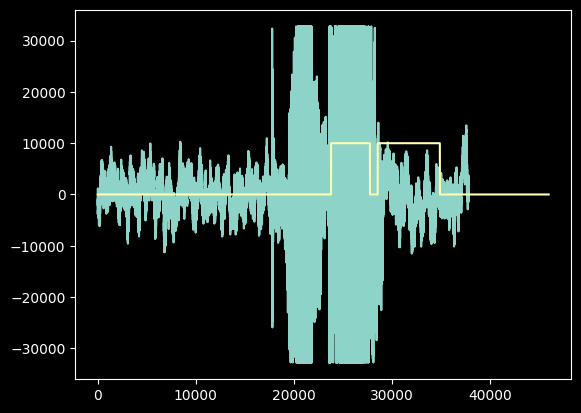

start   21.66896305222968
7


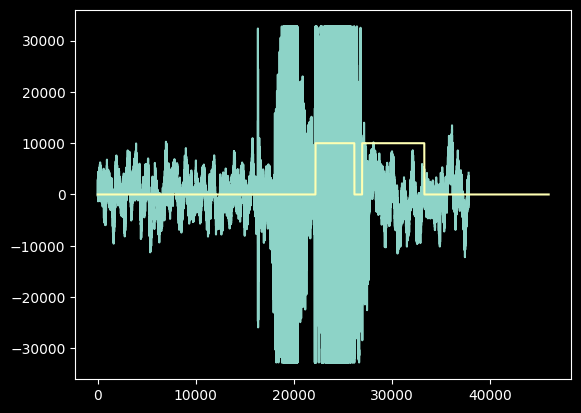

start   22.106981867460593
8


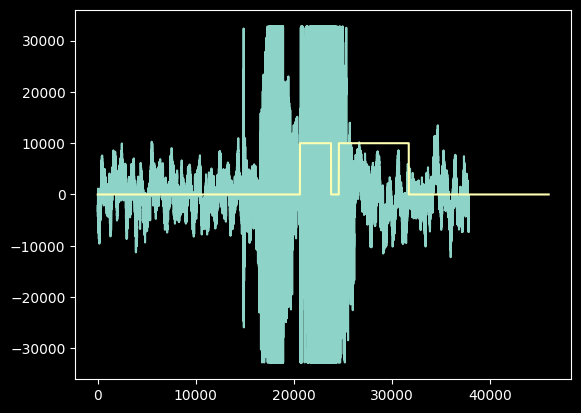

start   18.951460764829537
8


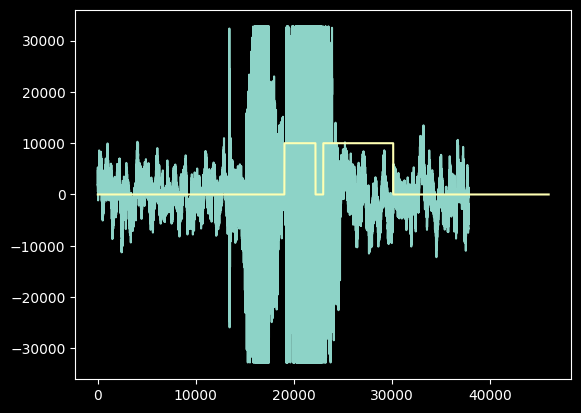

start   20.71413965308155
8


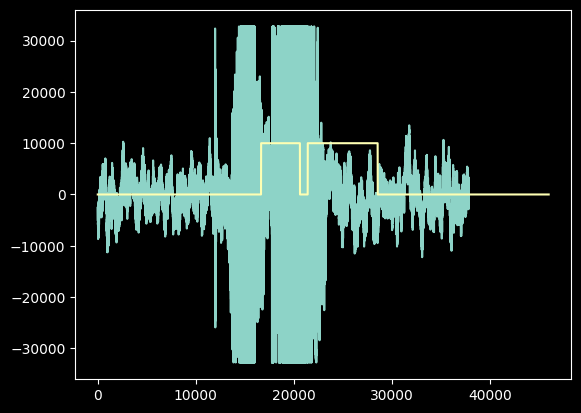

start   22.447677278566463
7


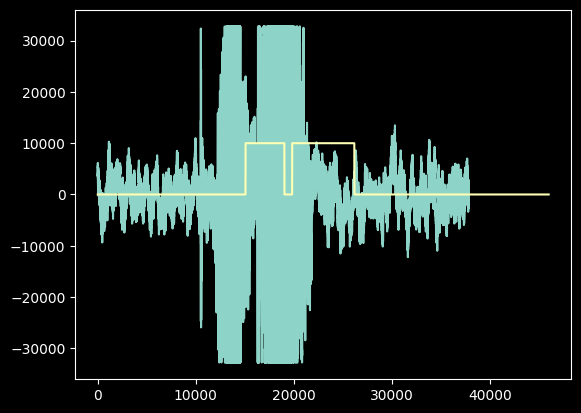

start   21.67935752054131
7


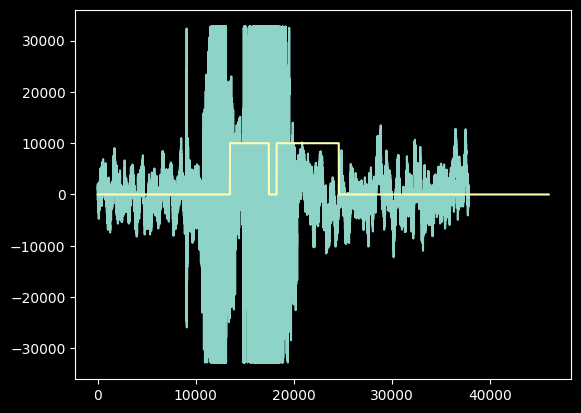

start   22.12933234585636
8


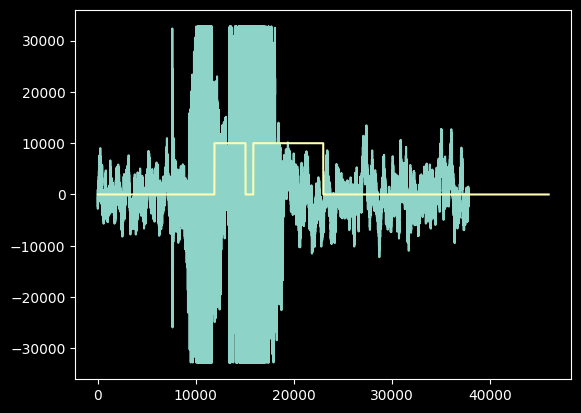

start   18.99235035121438
8


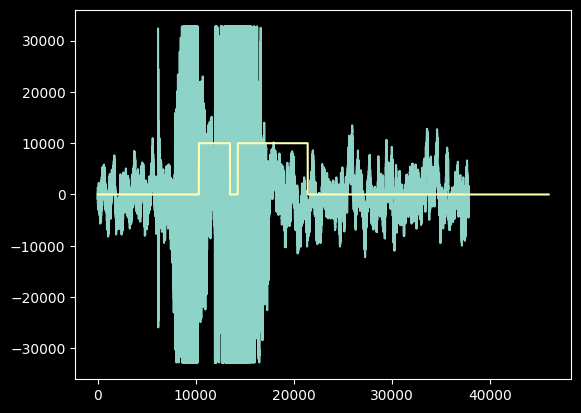

start   20.77592102887043
8


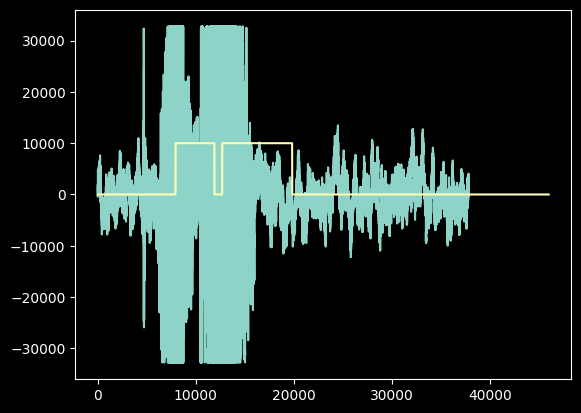

start   22.47170008138444
7


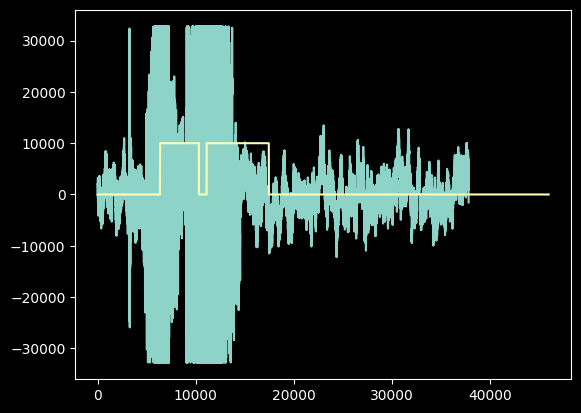

start   21.69065727863578
7


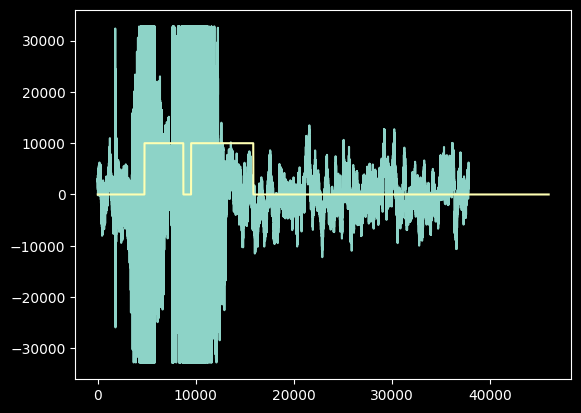

start   22.15236092347523
8


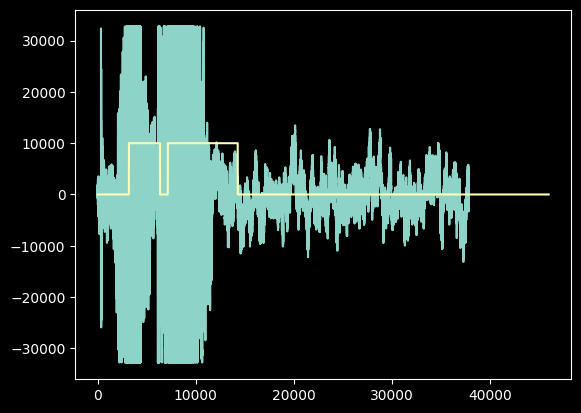

start   19.034070885342885
8


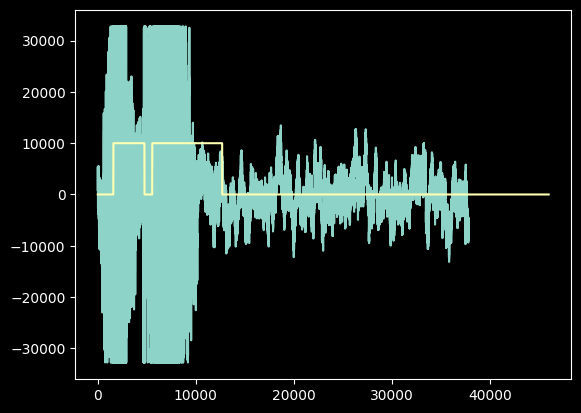

start   20.83816973929683
8


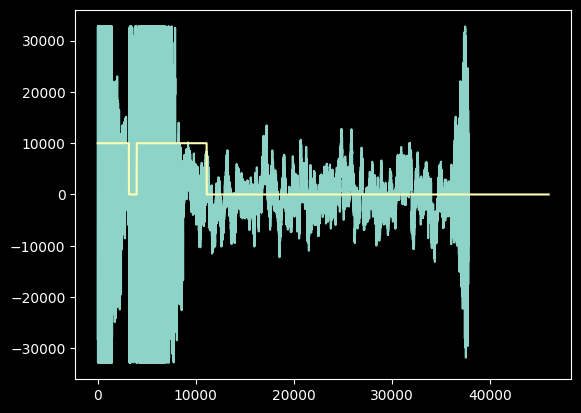

start   22.496019832203
7


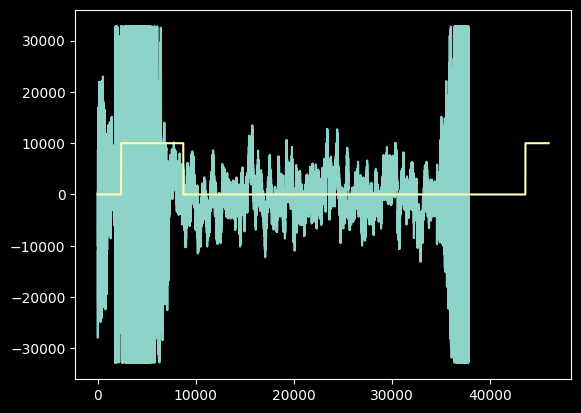

start   21.702864193394653
7


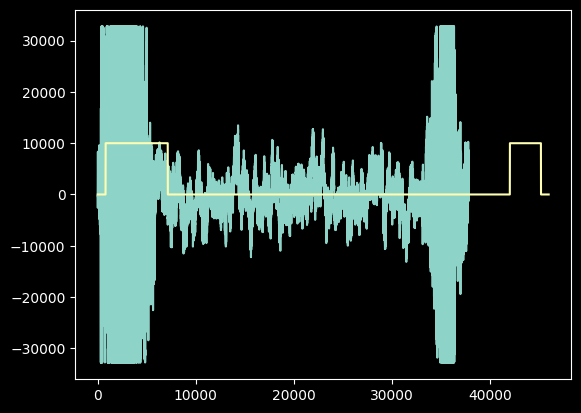

start   22.17604447326896
4


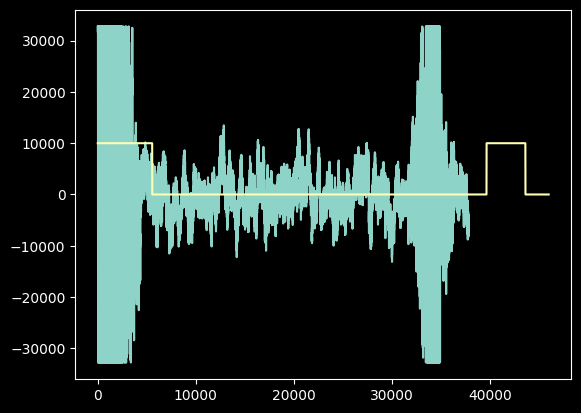

stop   35.60394670033181
3


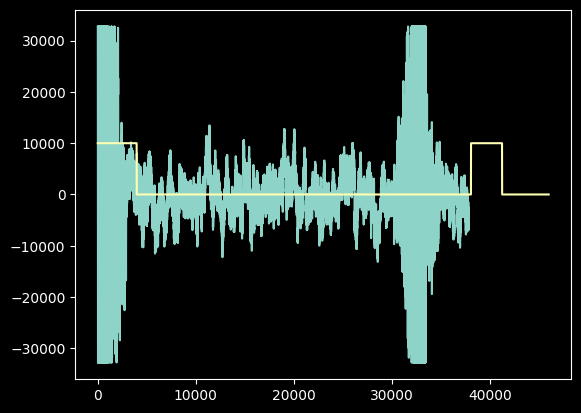

stop   36.13188430515157
3


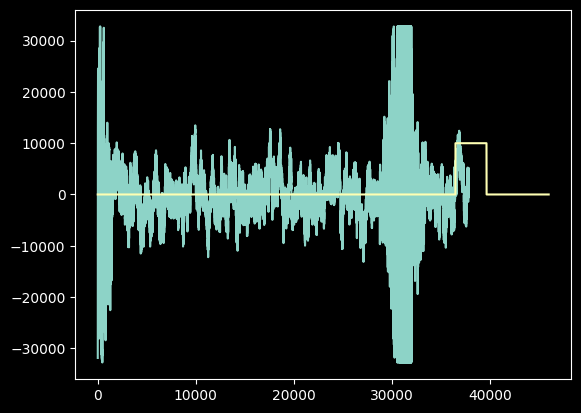

stop   35.76394367596262
3


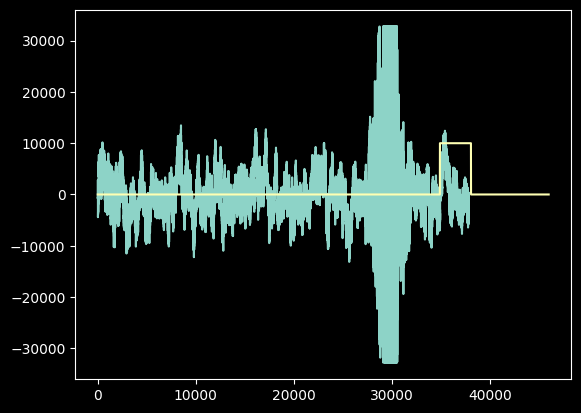

stop   35.85686304442347
4


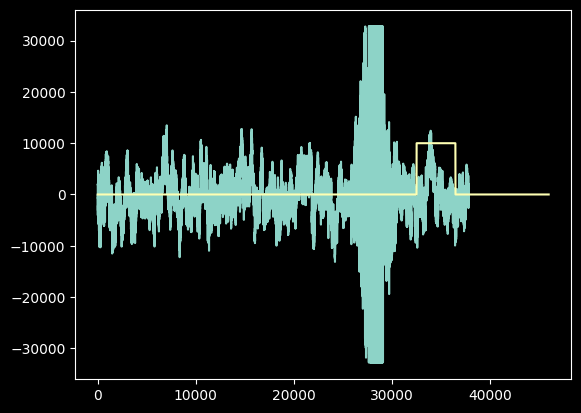

stop   35.7006426423715
4


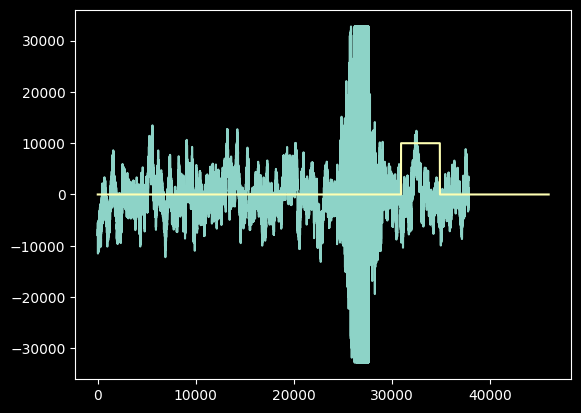

stop   35.587982982370946
3


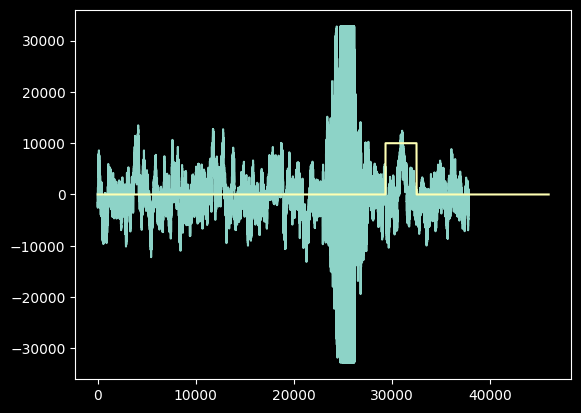

stop   36.108082627620604
3


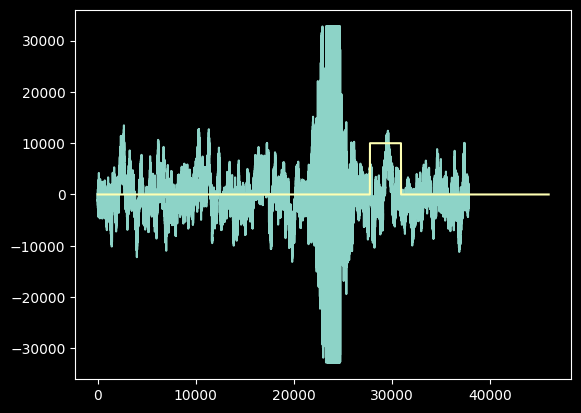

stop   35.76416356205392
3


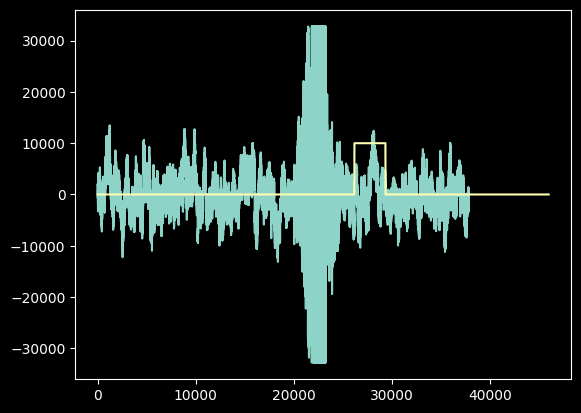

stop   35.85717968317864
4


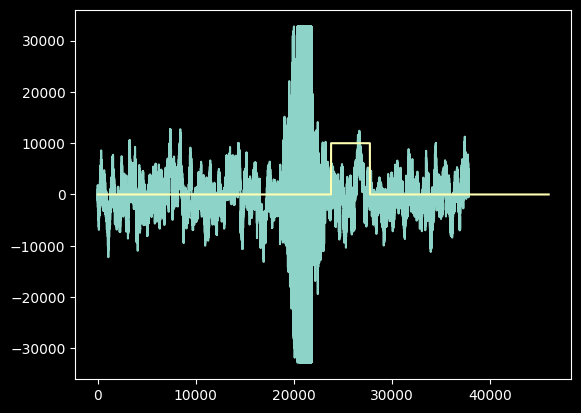

stop   35.707181164981996
4


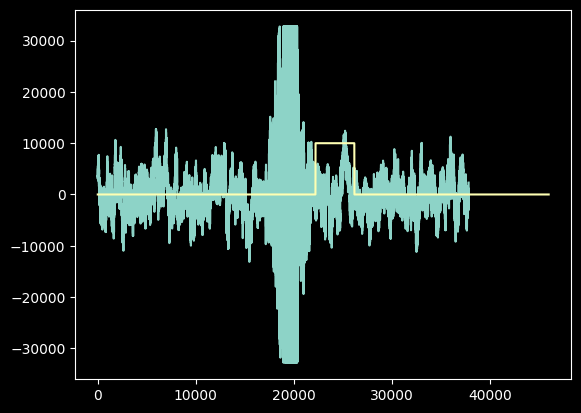

stop   35.57180235837491
3


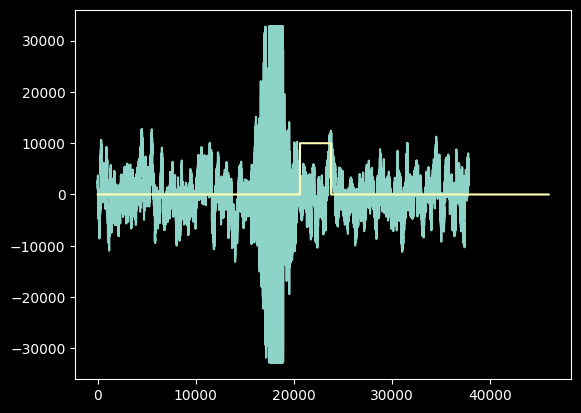

stop   36.0850782565506
3


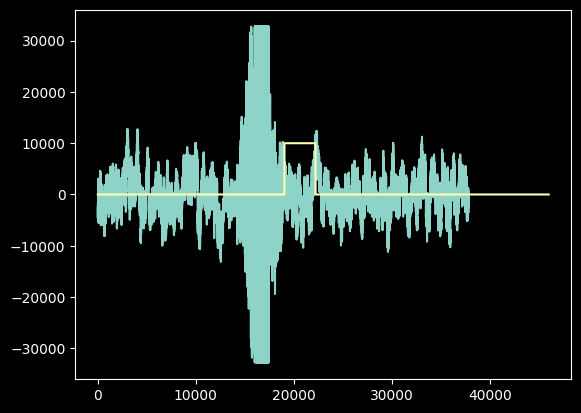

stop   35.76486587967908
3


KeyboardInterrupt: 

In [272]:
from collections import deque
import pyaudio
import wave

FORMAT = pyaudio.paInt16
CHUNK = int(stopFile_sample_rate * stft_frame_len)
p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=1,
                rate=startFile_sample_rate,
                input=True,
                frames_per_buffer=CHUNK)

samples = [(minusFile_mel, "minus"),
           (plusFile_mel, "plus"),
           (stopFile_mel, "stop"),
           (startFile_mel, "start"),
           (patiMinus_mel, "minusP"),
           (patiPlus_mel, "plusP"),
           (patiStart_mel, "startP"),
           (patiStop_mel, "stopP")]


buffer_size = max(len(mel) for mel, _ in samples) * 2

try:
    print("* recording")

    frames = []

    for i in range(buffer_size):
        data = stream.read(CHUNK)
        frames.append(data)

    frames = deque(frames, maxlen=len(frames))

    for i in range(buffer_size*2):
        data = stream.read(CHUNK)
        frames.append(data)

    full_buffer = b''.join(frames) # Join all chunks into one long byte string
    audio_data = np.frombuffer(full_buffer, dtype=np.int16) # Convert bytes to int16 integers
    frames_mel = spectrum_stft(audio_data.astype(np.float32), stopFile_sample_rate)

    noise_sample = frames_mel[0]
    noise_mean = np.mean(noise_sample)
    noise_std = np.std(noise_sample)
    K = 4
    calculated_threshold = noise_mean + (K * noise_std)
    calculated_threshold = 4
    print(f"Noise Floor: {noise_mean:.2f} ({noise_sample.min():.2f}/{noise_sample.max():.2f})")
    print(f"Threshold:   {calculated_threshold:.2f}")

    while True:
        data = stream.read(CHUNK)
        frames.append(data)
        full_buffer = b''.join(frames) # Join all chunks into one long byte string
        audio_data = np.frombuffer(full_buffer, dtype=np.int16) # Convert bytes to int16 integers
        frames_mel = spectrum_stft(audio_data.astype(np.float32), stopFile_sample_rate)
        s_map =  speach_map(frames_mel, calculated_threshold)
        label, num = find_match(samples, frames_mel, s_map)
        if True:
            _,ax=plt.subplots(1,1)
            vad = np.array([[w*10000]*int((stft_frame_len*noice_sample_rate - stft_frame_trans*noice_sample_rate)) for w in s_map]).flatten()
            ax.plot(audio_data)
            ax.plot(vad)
            plt.show()

        if label != "noise":
            start, end = find_longest_speech_sequence(s_map)
            print(label, " ", num)


finally:
    stream.stop_stream()
    stream.close()
    p.terminate()
